In [ ]:
#creates connectivity matrix
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data, datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()
#subs = ['sub-107'] #temporary checking the matrix for one subject

run_num = 3
runs = list(range(1, run_num + 1))

# Define the number of ROIs for the Schaefer atlas
n_rois = 200

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using standard space data"""
    logging.info(f"Processing subject: {ss}")
    
    # Load Schaefer atlas (already in MNI 2mm space)
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the atlas
        masker = NiftiLabelsMasker(
            labels_img=atlas_img,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save with modified filename to indicate standard space
            output_dir = f'{results_dir}/connectivity_matrices_{n_rois}_standard'
            os.makedirs(output_dir, exist_ok=True)
            np.save(f'{output_dir}/{ss}_connectivity_matrix_standard.npy', connectivity_matrix)
            logging.info(f'Saved standard space connectivity matrix for {ss}')

if __name__ == "__main__":
    main()

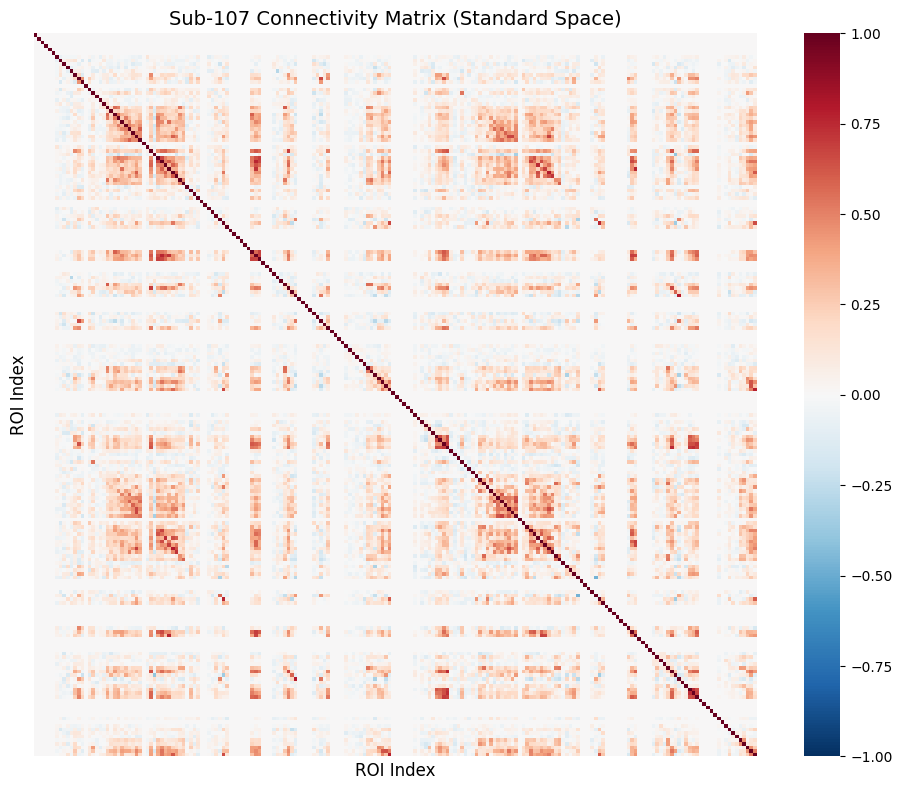

Matrix shape: (200, 200)
Mean correlation: 0.047
Standard deviation: 0.134
Min correlation: -0.471
Max correlation: 1.000


In [ ]:
#pre standardizing the data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the connectivity matrix
conn_matrix = np.load('results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy')

# Create figure with specific size
plt.figure(figsize=(10, 8))

# Create heatmap using seaborn
# Using 'RdBu_r' colormap which is good for correlation data (red-blue, reversed)
sns.heatmap(conn_matrix, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            xticklabels=False,
            yticklabels=False)

# Add title and labels
plt.title('Sub-107 Connectivity Matrix (Standard Space)', fontsize=14)
plt.xlabel('ROI Index', fontsize=12)
plt.ylabel('ROI Index', fontsize=12)

# Add colorbar label
#plt.colorbar(label='Correlation Coefficient')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print some basic statistics about the connectivity matrix
print(f"Matrix shape: {conn_matrix.shape}")
print(f"Mean correlation: {np.mean(conn_matrix):.3f}")
print(f"Standard deviation: {np.std(conn_matrix):.3f}")
print(f"Min correlation: {np.min(conn_matrix):.3f}")
print(f"Max correlation: {np.max(conn_matrix):.3f}")


Summary Statistics:
       mean_correlation  std_deviation  min_correlation  max_correlation
count         19.000000      19.000000        19.000000             19.0
mean           0.059158       0.163056        -0.576339              1.0
std            0.012664       0.017948         0.102329              0.0
min            0.029959       0.133682        -0.807836              1.0
25%            0.052794       0.151564        -0.624709              1.0
50%            0.057294       0.158524        -0.561366              1.0
75%            0.066182       0.172628        -0.513428              1.0
max            0.079471       0.196796        -0.397413              1.0


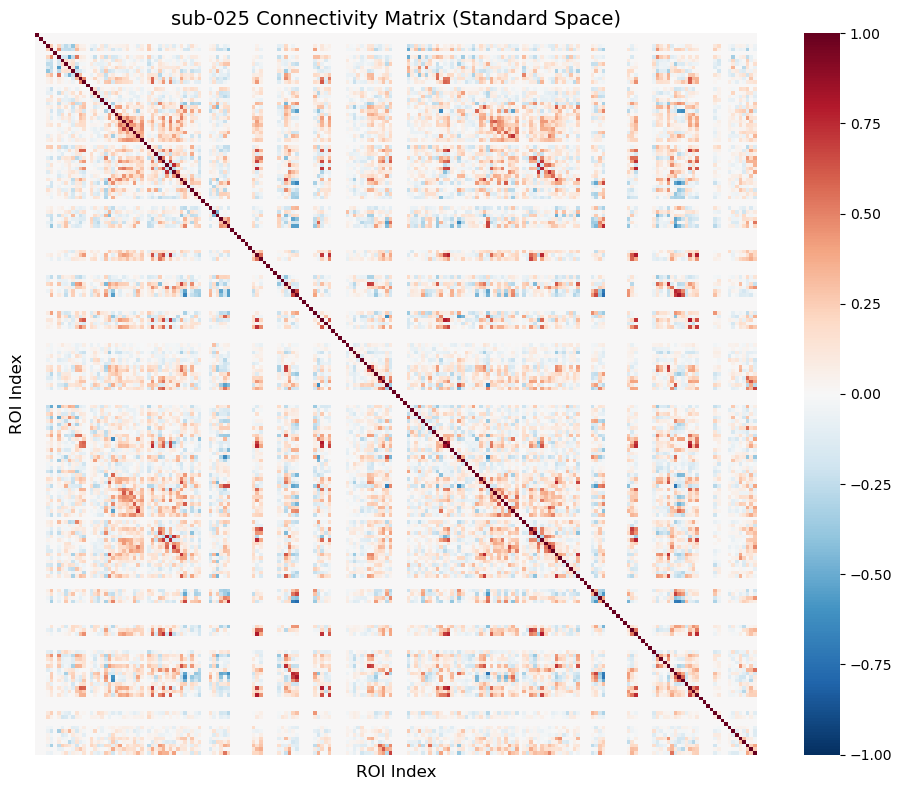

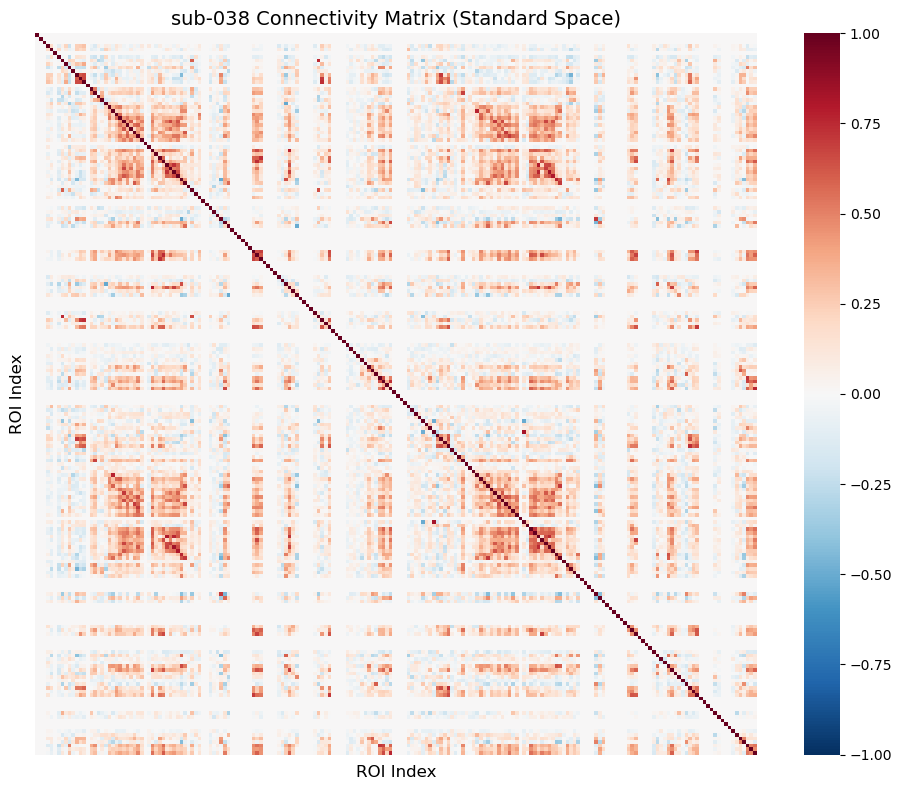

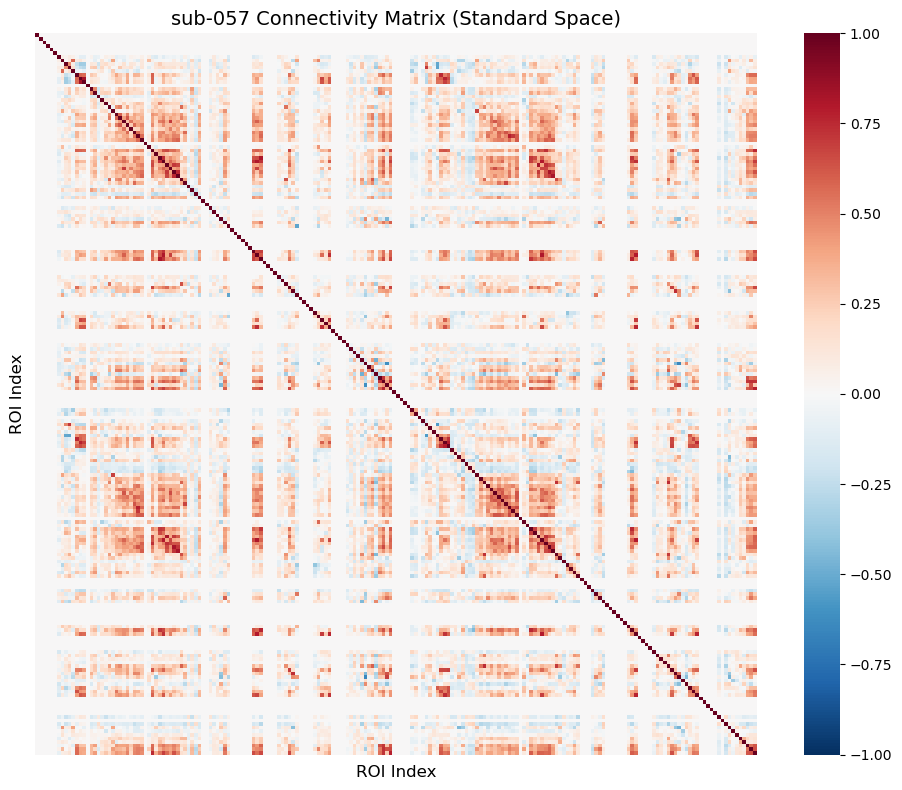

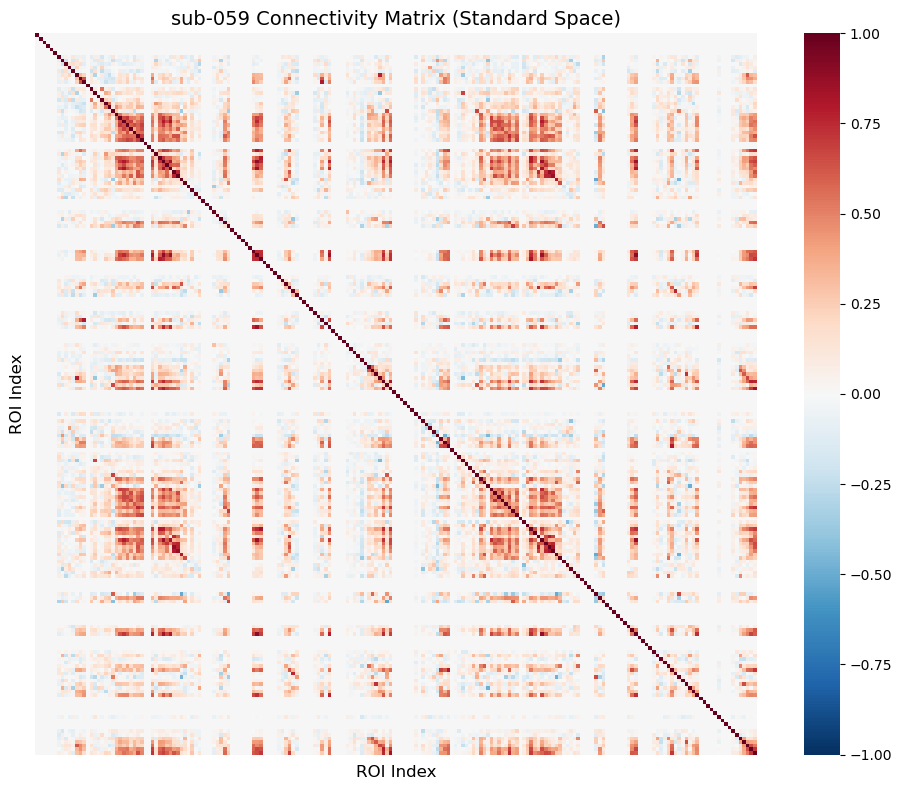

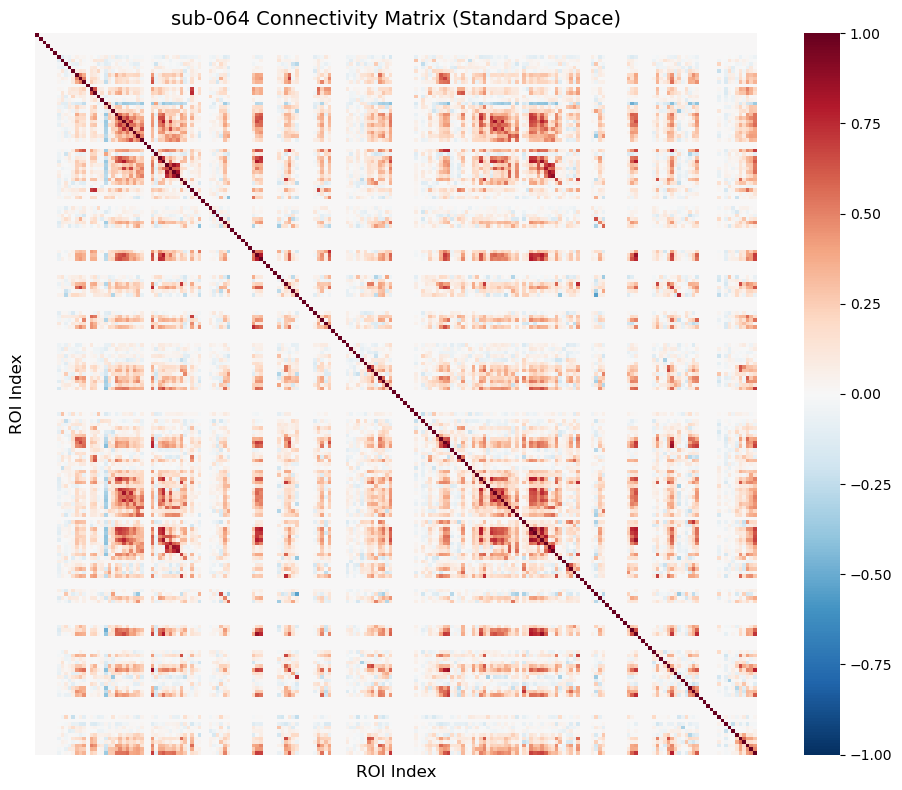

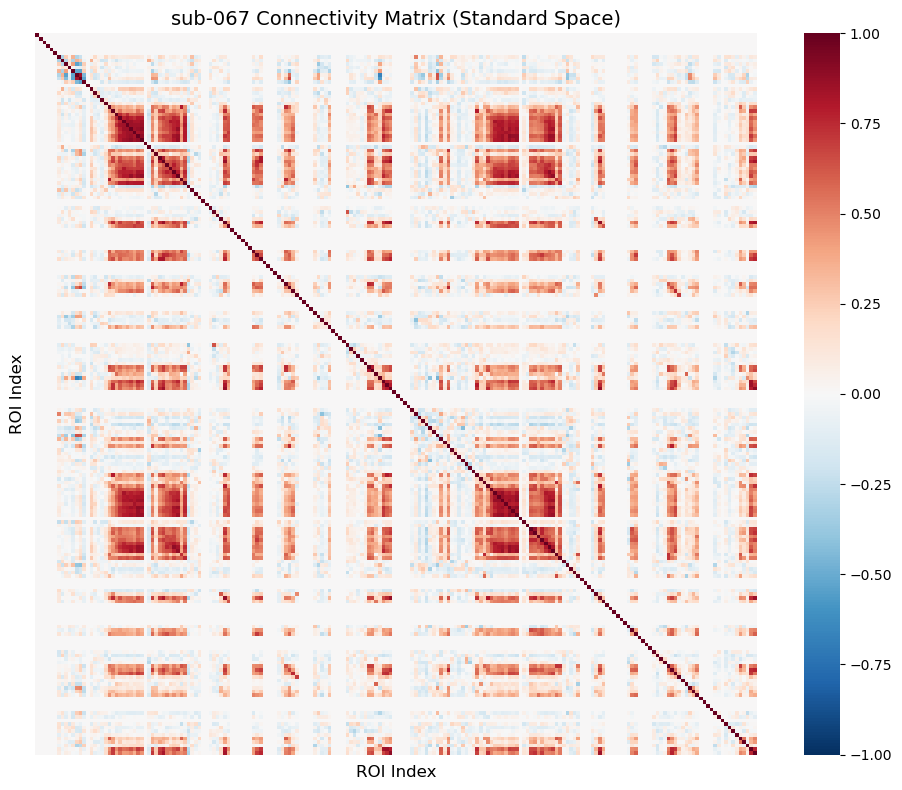

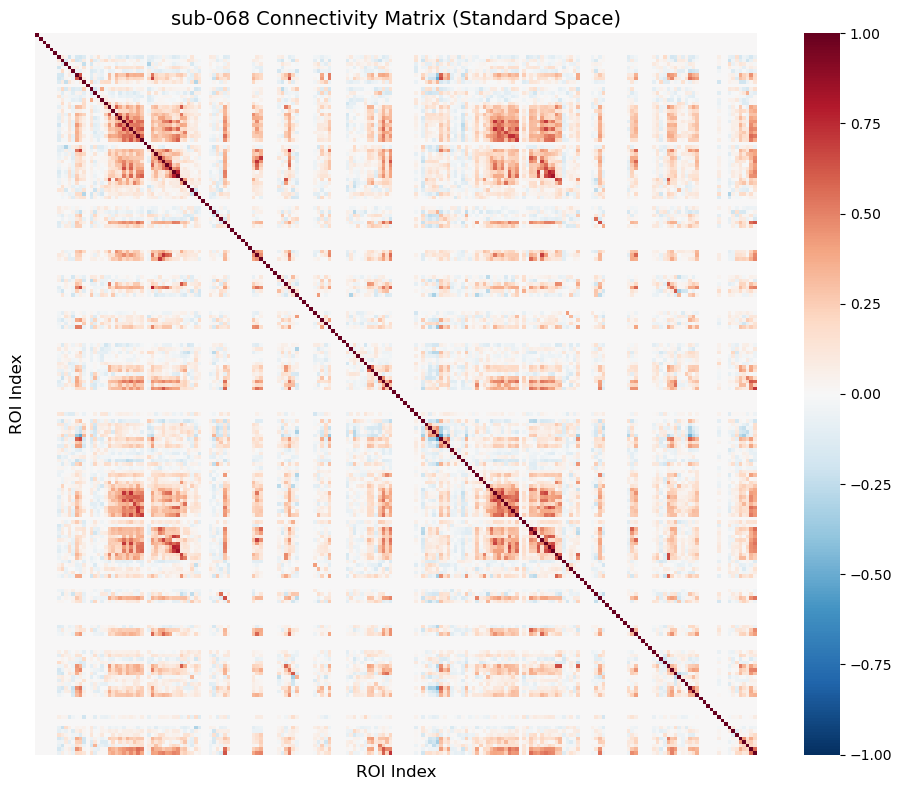

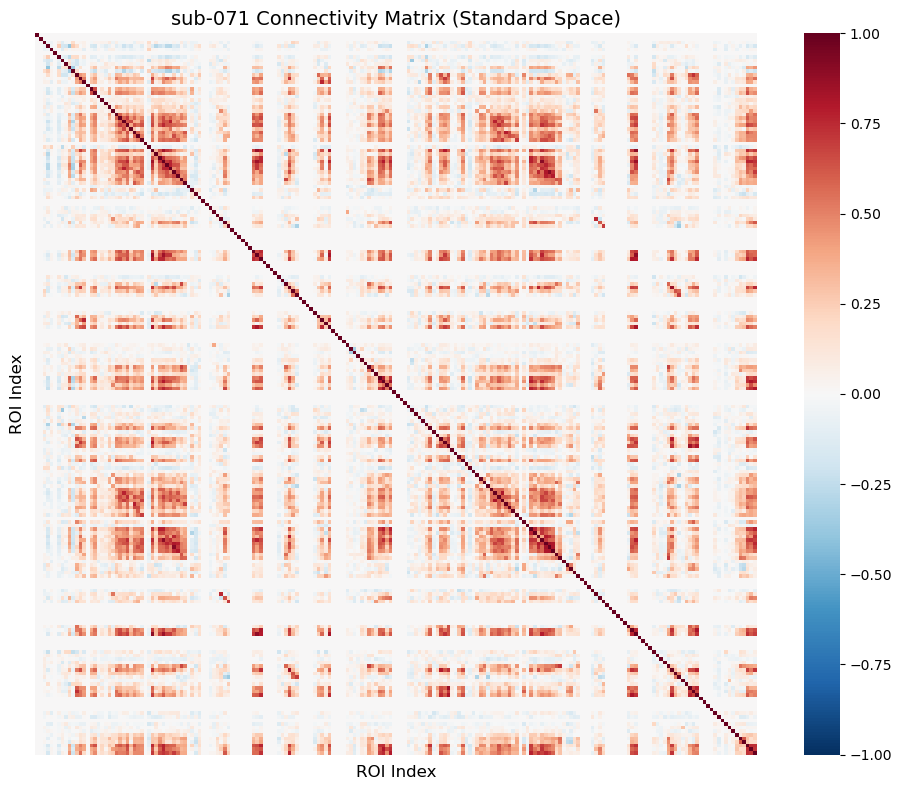

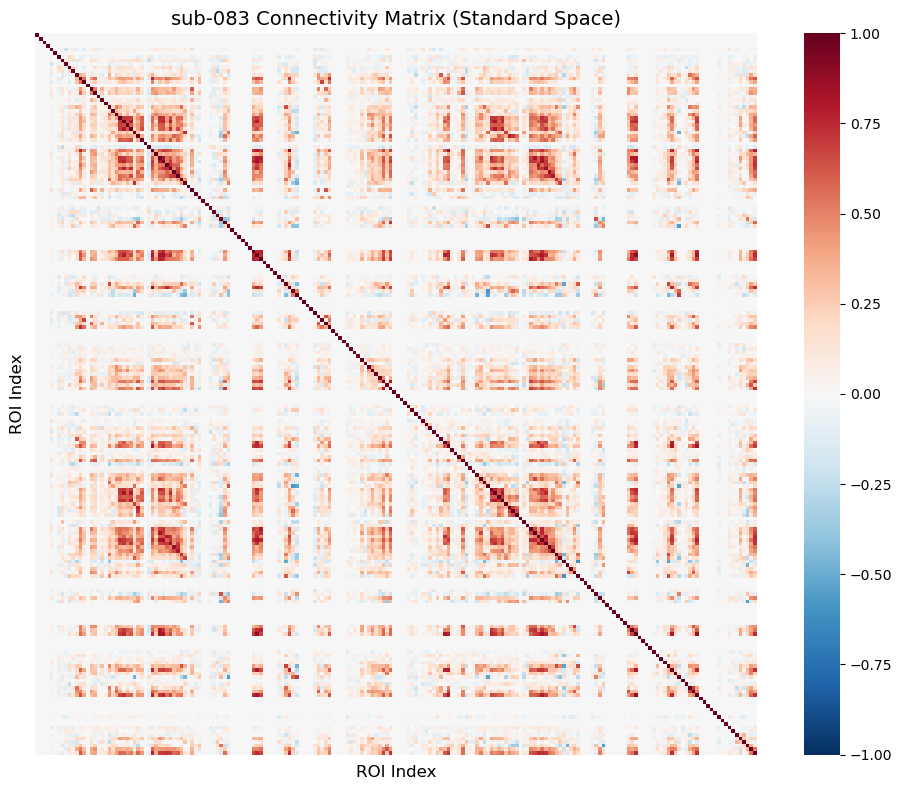

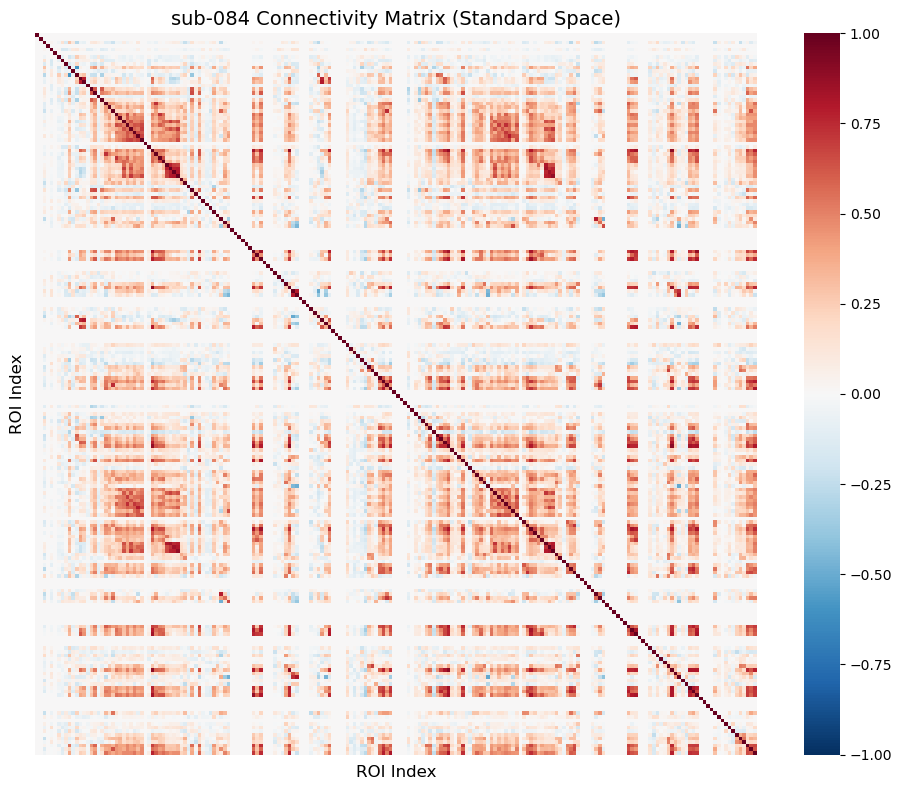

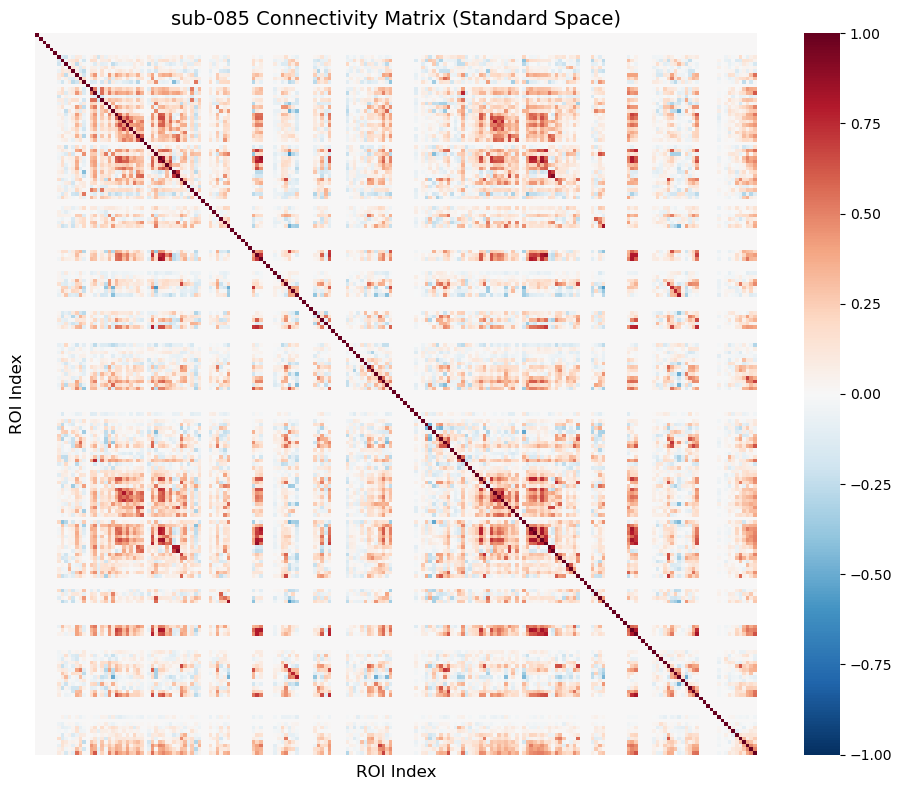

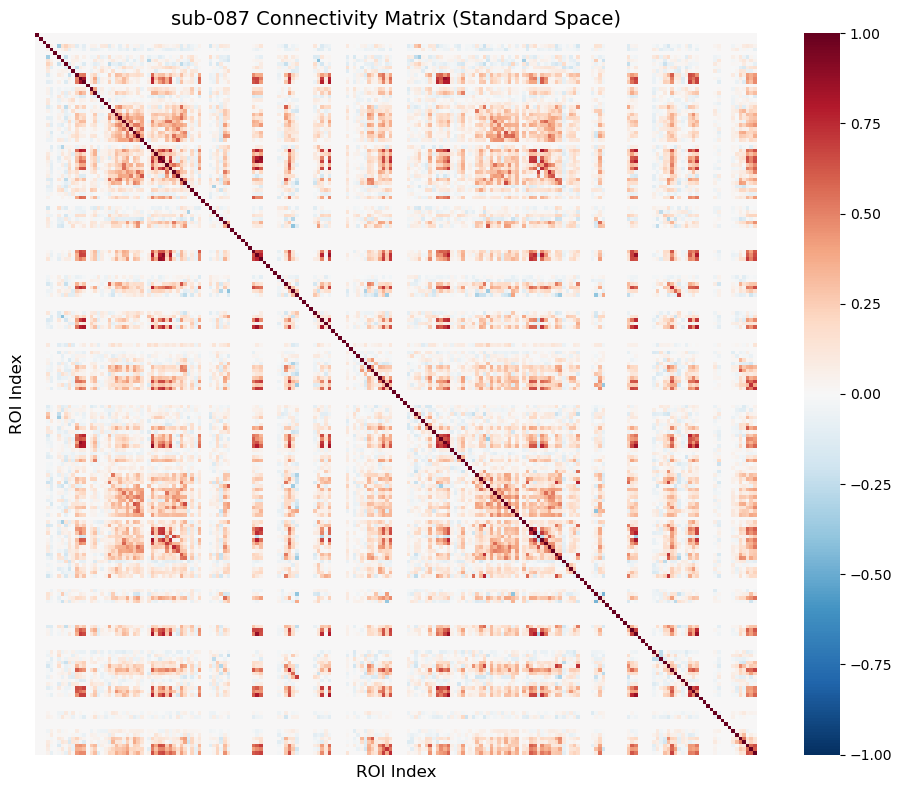

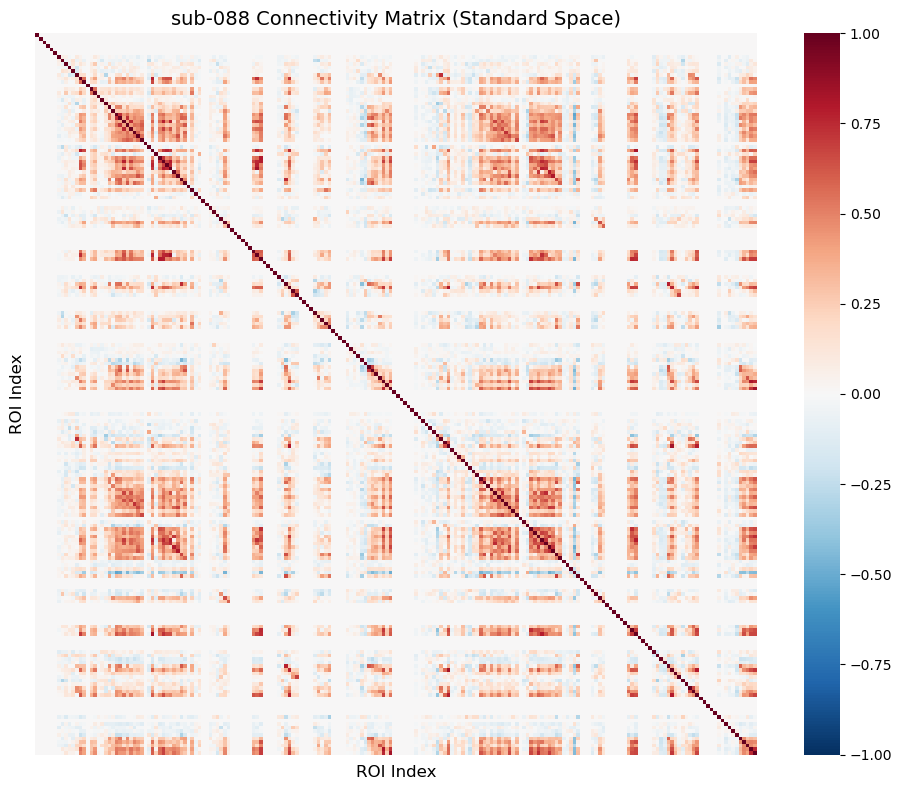

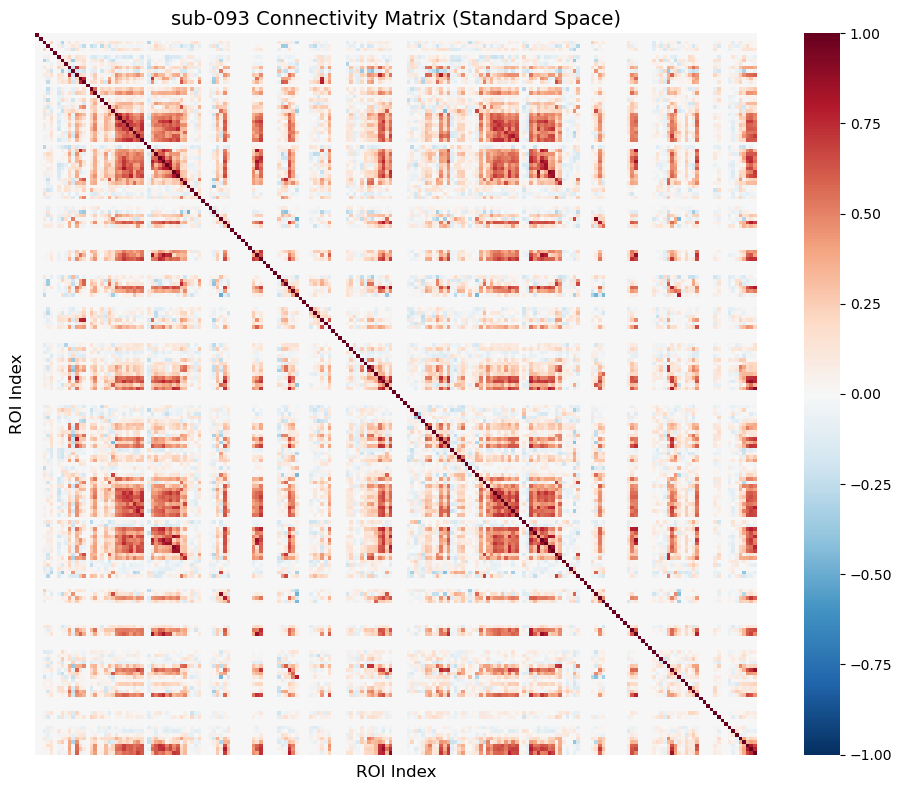

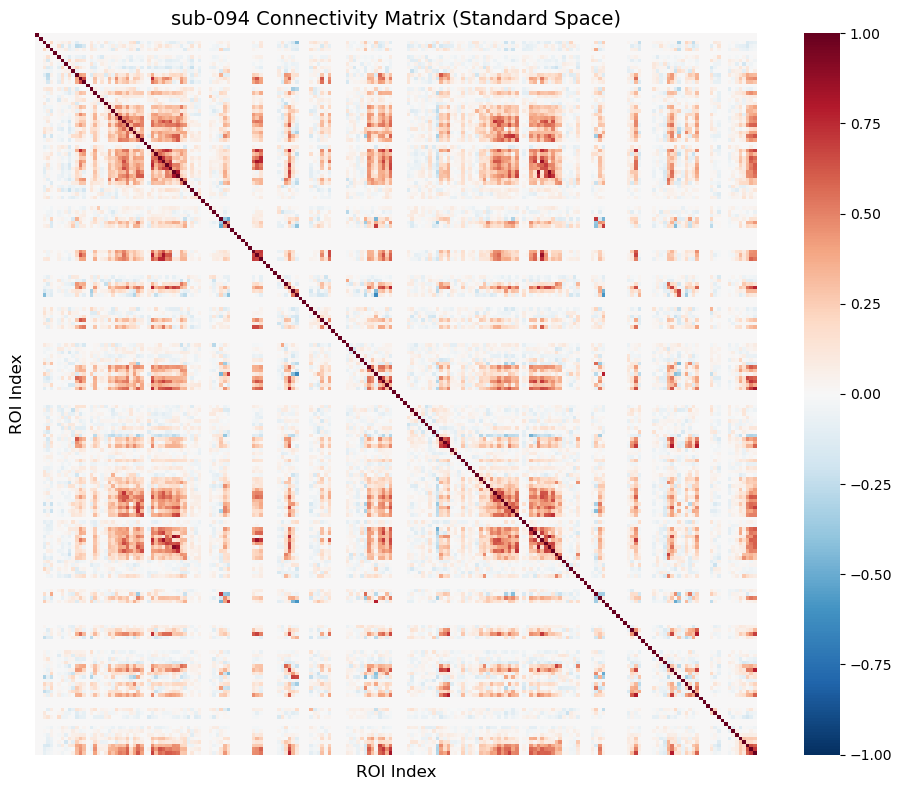

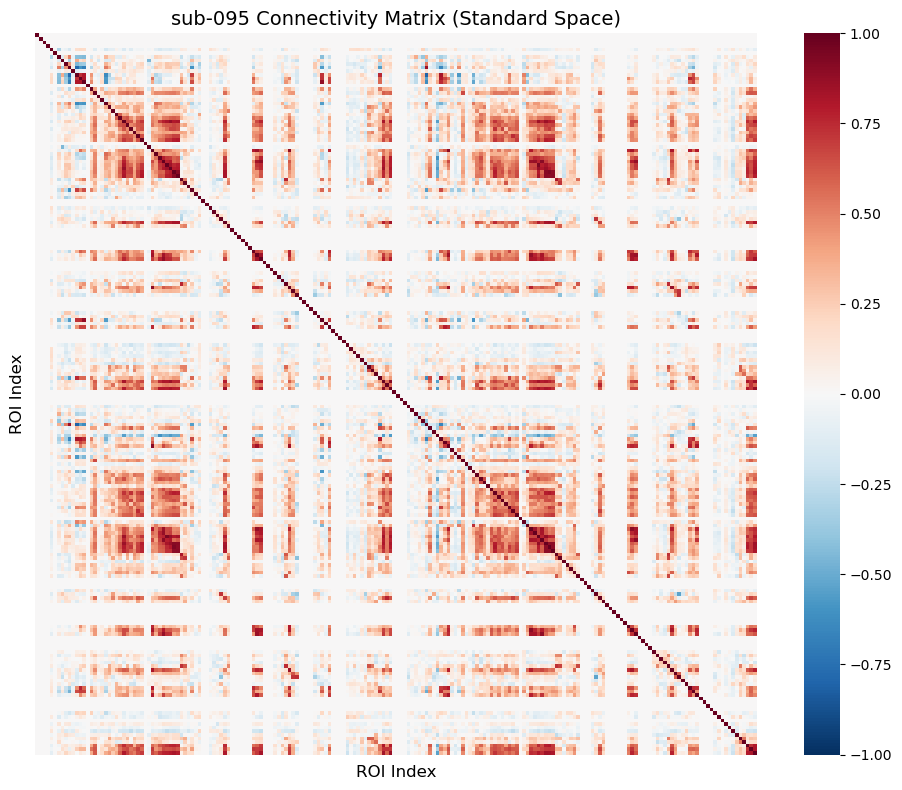

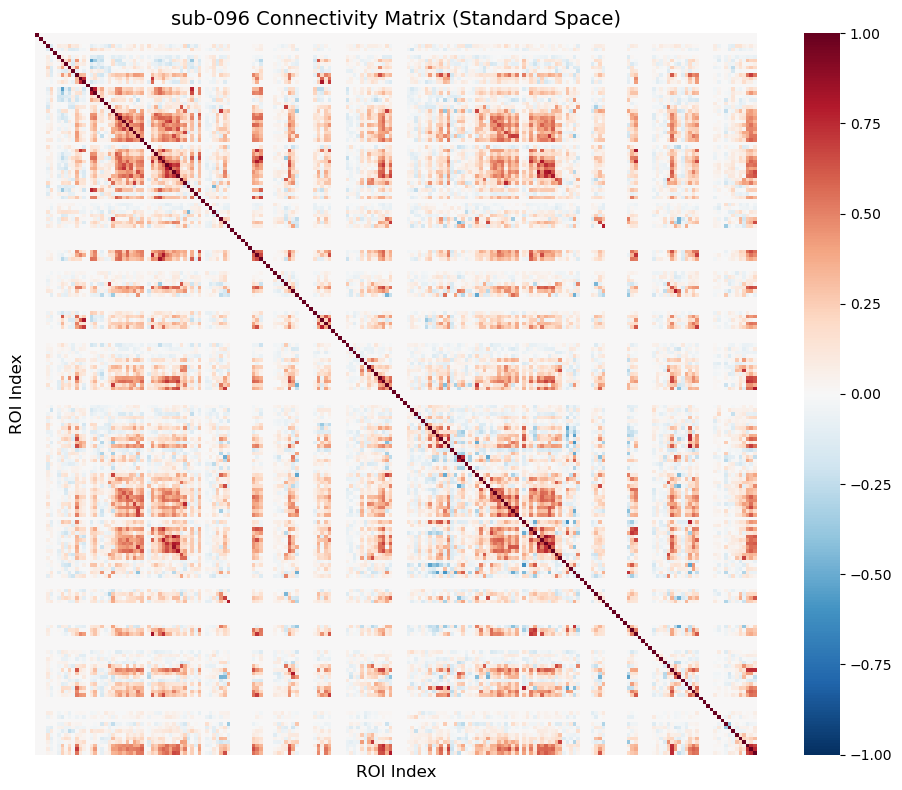

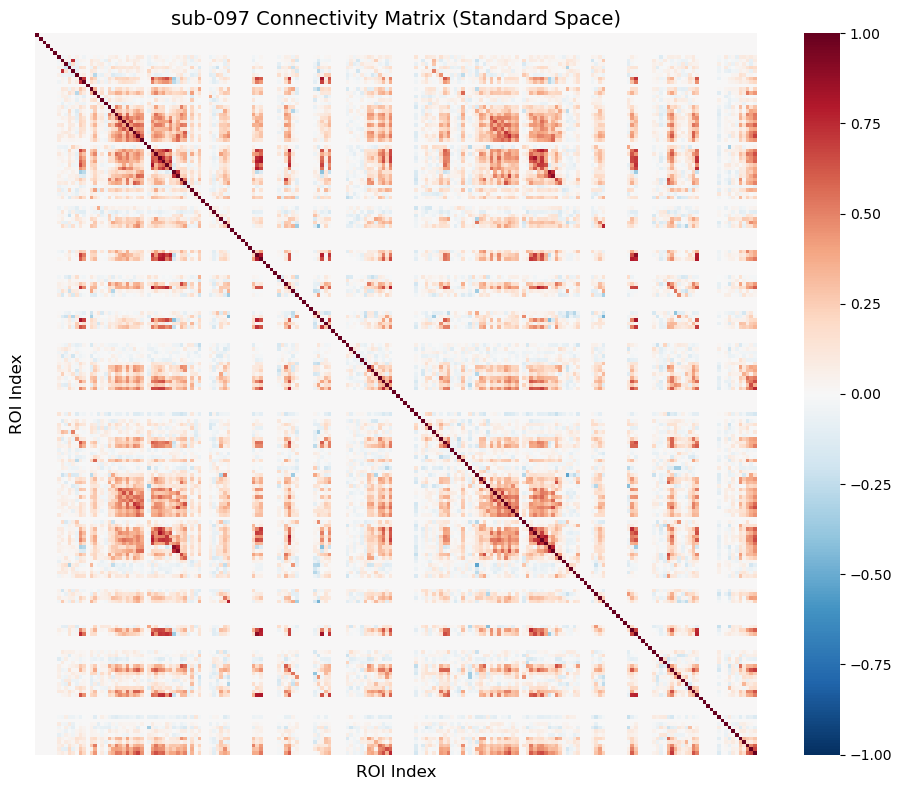

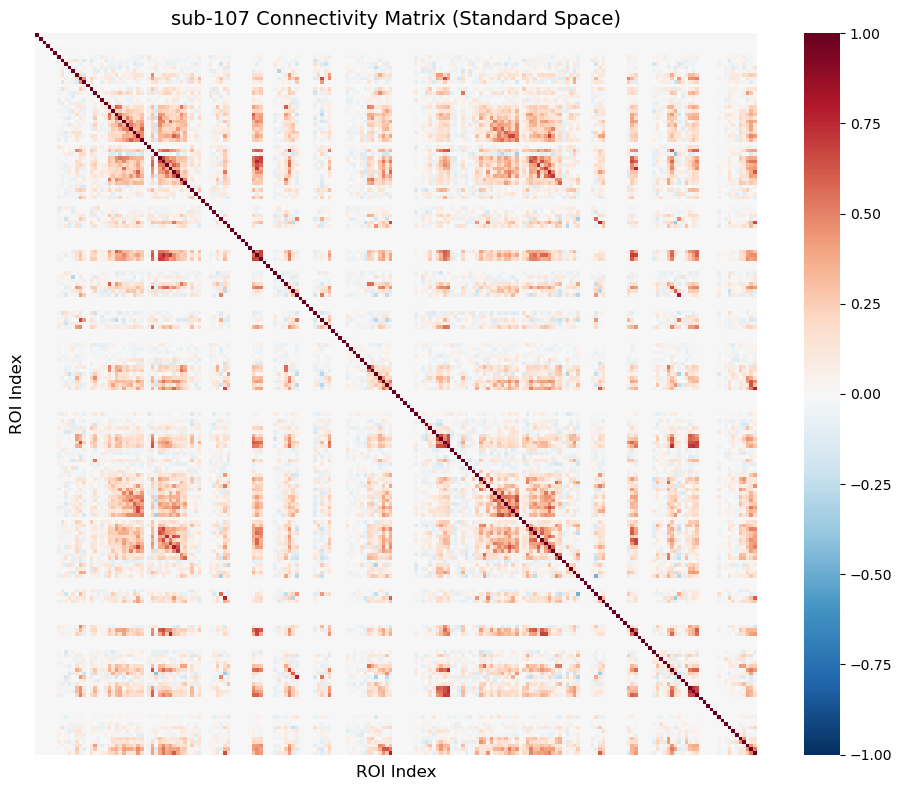

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import os

# Create output directory if it doesn't exist
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

# Load subject information
curr_dir = "."  # Adjust if needed
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & 
                (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Initialize lists to store statistics
all_stats = []

# Process each subject
for sub in subs:
    try:
        # Load the connectivity matrix
        matrix_path = f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy'
        conn_matrix = np.load(matrix_path)
        
        # Calculate statistics
        stats = {
            'subject': sub,
            'mean_correlation': np.mean(conn_matrix),
            'std_deviation': np.std(conn_matrix),
            'min_correlation': np.min(conn_matrix),
            'max_correlation': np.max(conn_matrix)
        }
        all_stats.append(stats)
        
        # Create visualization
        plt.figure(figsize=(10, 8))
        
        # Create heatmap
        sns.heatmap(conn_matrix, 
                   cmap='RdBu_r',
                   center=0,
                   vmin=-1,
                   vmax=1,
                   square=True,
                   xticklabels=False,
                   yticklabels=False)
        
        # Add title and labels
        plt.title(f'{sub} Connectivity Matrix (Standard Space)', fontsize=14)
        plt.xlabel('ROI Index', fontsize=12)
        plt.ylabel('ROI Index', fontsize=12)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f'{output_dir}/{sub}_connectivity_matrix.png', dpi=300, bbox_inches='tight')
        #plt.close()
        
    except Exception as e:
        print(f"Error processing subject {sub}: {str(e)}")
        continue

# Convert statistics to DataFrame
stats_df = pd.DataFrame(all_stats)

# Save statistics
stats_df.to_csv(f'{output_dir}/connectivity_statistics.csv', index=False)

# Create summary visualizations
plt.figure(figsize=(12, 6))

# Plot distribution of mean correlations
plt.subplot(121)
sns.histplot(stats_df['mean_correlation'], kde=True)
plt.title('Distribution of Mean Correlations')
plt.xlabel('Mean Correlation')

# Plot distribution of standard deviations
plt.subplot(122)
sns.histplot(stats_df['std_deviation'], kde=True)
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation')

plt.tight_layout()
plt.savefig(f'{output_dir}/summary_statistics.png', dpi=300, bbox_inches='tight')
plt.close()

# Display summary statistics
print("\nSummary Statistics:")
print(stats_df.describe())

In [8]:
# Check for NaN values
print("NaN values:", np.isnan(conn_matrix).any())

# Check symmetry
is_symmetric = np.allclose(conn_matrix, conn_matrix.T)
print("Matrix is symmetric:", is_symmetric)

# Check diagonal values
diagonal_ones = np.allclose(np.diag(conn_matrix), 1.0)
print("Diagonal values are 1:", diagonal_ones)

# Check value range
in_range = ((conn_matrix >= -1.0) & (conn_matrix <= 1.0)).all()
print("All values between -1 and 1:", in_range)

# Count strong connections
strong_connections = np.sum(np.abs(conn_matrix) > 0.5) / 2  # Divide by 2 due to symmetry
print(f"Number of strong connections (|r| > 0.5): {strong_connections}")

NaN values: False
Matrix is symmetric: True
Diagonal values are 1: True
All values between -1 and 1: True
Number of strong connections (|r| > 0.5): 301.0


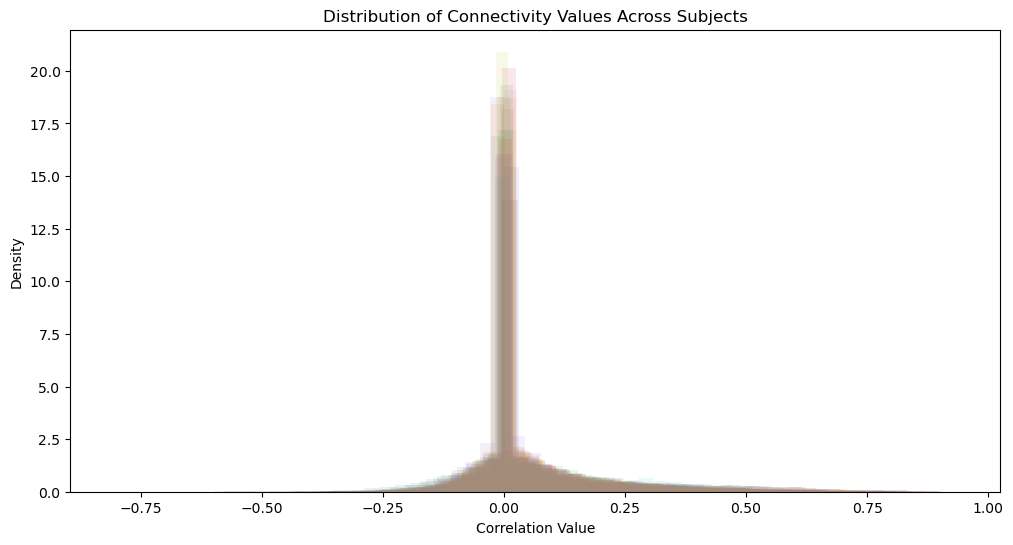

In [10]:
# Plot distribution of connectivity values for each subject
plt.figure(figsize=(12, 6))
for sub in subs:
    matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
    plt.hist(matrix[np.tril_indices_from(matrix, k=-1)], 
             bins=50, alpha=0.1, density=True)
plt.title('Distribution of Connectivity Values Across Subjects')
plt.xlabel('Correlation Value')
plt.ylabel('Density')
plt.show()

In [11]:
# Check for outlier subjects
for sub in subs:
    matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
    mean_conn = np.mean(matrix[np.tril_indices_from(matrix, k=-1)])
    std_conn = np.std(matrix[np.tril_indices_from(matrix, k=-1)])
    print(f"Subject {sub}: Mean = {mean_conn:.3f}, Std = {std_conn:.3f}")

# Calculate sparsity (proportion of strong connections)
total_possible = (matrix.shape[0] * (matrix.shape[0] - 1)) / 2
sparsity = (301 / total_possible) * 100
print(f"\nNetwork sparsity: {sparsity:.2f}% of connections are strong (|r| > 0.5)")

Subject sub-025: Mean = 0.025, Std = 0.133
Subject sub-038: Mean = 0.048, Std = 0.136
Subject sub-057: Mean = 0.053, Std = 0.151
Subject sub-059: Mean = 0.049, Std = 0.144
Subject sub-064: Mean = 0.057, Std = 0.142
Subject sub-067: Mean = 0.062, Std = 0.186
Subject sub-068: Mean = 0.040, Std = 0.119
Subject sub-071: Mean = 0.072, Std = 0.166
Subject sub-083: Mean = 0.061, Std = 0.154
Subject sub-084: Mean = 0.075, Std = 0.171
Subject sub-085: Mean = 0.049, Std = 0.143
Subject sub-087: Mean = 0.054, Std = 0.138
Subject sub-088: Mean = 0.052, Std = 0.150
Subject sub-093: Mean = 0.073, Std = 0.175
Subject sub-094: Mean = 0.046, Std = 0.136
Subject sub-095: Mean = 0.072, Std = 0.186
Subject sub-096: Mean = 0.055, Std = 0.149
Subject sub-097: Mean = 0.051, Std = 0.135
Subject sub-107: Mean = 0.042, Std = 0.116

Network sparsity: 1.51% of connections are strong (|r| > 0.5)


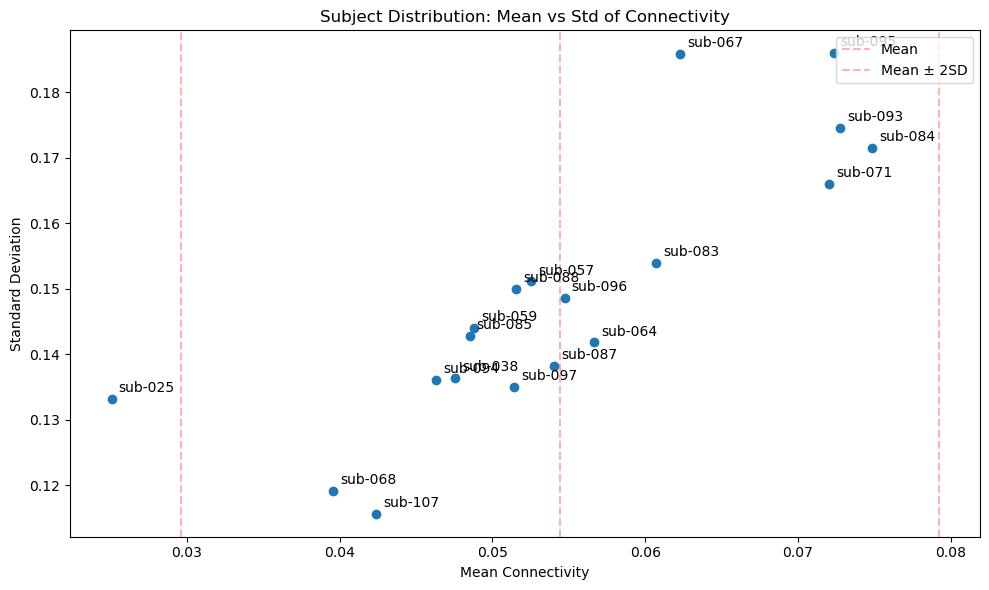

In [15]:
# Create scatter plot of mean vs std for each subject
plt.figure(figsize=(10, 6))

# Calculate means and stds for each subject
means = []
stds = []
for sub in subs:
    matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
    # Calculate using lower triangle of matrix (excluding diagonal)
    lower_triangle = matrix[np.tril_indices_from(matrix, k=-1)]
    means.append(np.mean(lower_triangle))
    stds.append(np.std(lower_triangle))

plt.scatter(means, stds)
for i, sub in enumerate(subs):
    plt.annotate(f'{sub}', (means[i], stds[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('Mean Connectivity')
plt.ylabel('Standard Deviation')
plt.title('Subject Distribution: Mean vs Std of Connectivity')

# Add reference lines for mean ± 2SD
mean_of_means = np.mean(means)
std_of_means = np.std(means)
plt.axvline(mean_of_means, color='r', linestyle='--', alpha=0.3, label='Mean')
plt.axvline(mean_of_means + 2*std_of_means, color='r', linestyle='--', alpha=0.3, label='Mean ± 2SD')
plt.axvline(mean_of_means - 2*std_of_means, color='r', linestyle='--', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()